In [2]:
# read this dictionary and print the structure of this dictionary
path = '/Users/leo/Desktop/DeepPostures_MAE/MoCA/subject_level_performance/CNNBiLSTMModel/hipset_1.0_blr_0.001_bs_512_input_size_[3, 4200]_subject_performance.pkl'
import pickle
with open(path, 'rb') as f:
    data = pickle.load(f)

moca_path = '/Users/leo/Desktop/DeepPostures_MAE/MoCA/subject_level_performance/moca_shallow/hipLP_blr_0.001_bs_256_input_size_[3, 100]_subject_performance.pkl'
with open(moca_path, 'rb') as f:
    moca_data = pickle.load(f)


print(data['train'])
print(moca_data['train'])

{'i0002A': {'bal_acc': 92.74740517139435, 'f1': 94.1965401172638}, 'i0003A': {'bal_acc': 93.53022575378418, 'f1': 95.28899192810059}, 'i0005A': {'bal_acc': 89.28866982460022, 'f1': 89.62870836257935}, 'i0011A': {'bal_acc': 91.0578727722168, 'f1': 92.70988702774048}, 'i0016A': {'bal_acc': 94.60636377334595, 'f1': 94.35254335403442}, 'i0016B': {'bal_acc': 96.06621265411377, 'f1': 96.12199068069458}, 'i0017A': {'bal_acc': 87.26752400398254, 'f1': 92.4297571182251}, 'i0024A': {'bal_acc': 95.29561400413513, 'f1': 96.45819664001465}, 'i0025B': {'bal_acc': 93.99827718734741, 'f1': 95.53937911987305}, 'i0032A': {'bal_acc': 91.6603535413742, 'f1': 93.90319585800171}, 'i0032B': {'bal_acc': 96.04389369487762, 'f1': 96.71963453292847}, 'i0034A': {'bal_acc': 89.42307829856873, 'f1': 97.51308560371399}, 'i0036A': {'bal_acc': 92.8644061088562, 'f1': 92.86280870437622}, 'i0037A': {'bal_acc': 52.39691734313965, 'f1': 49.08006489276886}, 'i0045A': {'bal_acc': 95.7740306854248, 'f1': 96.58320546150208}, 

In [13]:
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_model_comparison(data_paths, model_names=None):
    '''
    data_paths: list of file paths to .pkl files, each containing performance per subject per split
    model_names: optional list of names for each model. If None, will use filename prefixes
    '''

    def collect_metric_data(subject_dict, split_name, model_name):
        df = pd.DataFrame.from_dict(subject_dict, orient='index')
        df['subject_id'] = df.index
        df['split'] = split_name
        df['model'] = model_name
        return df

    dfs = []

    for idx, path in enumerate(data_paths):
        with open(path, 'rb') as f:
            data = pickle.load(f)

        model_name = model_names[idx] if model_names else os.path.basename(path).split('/')[0]

        for split_name in ['train', 'val', 'test']:
            if split_name in data:
                dfs.append(collect_metric_data(data[split_name], split_name, model_name))

    # Combine and reshape
    all_df = pd.concat(dfs, ignore_index=True)
    melted = all_df.melt(id_vars=['subject_id', 'split', 'model'], 
                         value_vars=['bal_acc', 'f1'],
                         var_name='Metric', 
                         value_name='Score')

    # Plot
    sns.set(style='whitegrid', context='paper', font_scale=1.4)
    g = sns.catplot(
        data=melted, kind='box',
        x='Metric', y='Score', hue='model', col='split',
        palette='Set2', height=6, aspect=1
    )
    g.set_axis_labels("Metric", "Score (%)")
    g.set_titles("Split: {col_name}")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return all_df


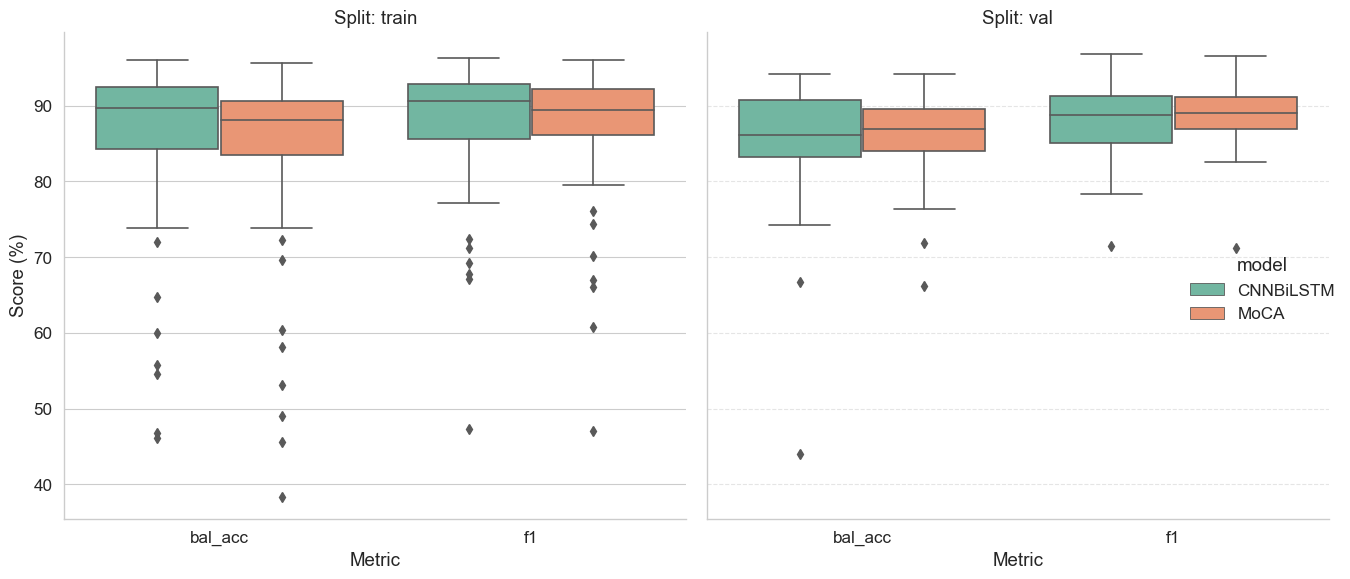

In [15]:
data_paths = [
    '/Users/leo/Desktop/DeepPostures_MAE/MoCA/subject_level_performance/CNNBiLSTMModel/wristset_1.0_blr_0.001_bs_512_input_size_[3, 4200]_subject_performance.pkl',
    '/Users/leo/Desktop/DeepPostures_MAE/MoCA/subject_level_performance/moca_shallow/wristLP_blr_0.001_bs_256_input_size_[3, 100]_subject_performance.pkl'
]

model_names = ['CNNBiLSTM', 'MoCA']

wrist_df = plot_model_comparison(data_paths, model_names)


In [25]:
def align_top_10_worst_subjects(df):
    df_sorted = df.sort_values(by='bal_acc', ascending=True)
    model_names = df_sorted['model'].unique()

    # Get top 10 worst subject_ids per model
    worst_subjects = {}
    for model in model_names:
        worst_subjects[model] = (
            df_sorted[df_sorted['model'] == model]
            .head(10)['subject_id']
            .tolist()
        )

    # Combine all subject_ids that appear in any top-10 list
    combined_subjects = set()
    for ids in worst_subjects.values():
        combined_subjects.update(ids)

    # For each subject_id, get bal_acc for each model
    rows = []
    for sid in sorted(combined_subjects):
        row = {'subject_id': sid}
        for model in model_names:
            model_df = df_sorted[df_sorted['model'] == model]
            match = model_df[model_df['subject_id'] == sid]
            if not match.empty:
                row[f'{model}_bal_acc'] = match.iloc[0]['bal_acc']
            else:
                row[f'{model}_bal_acc'] = None
        rows.append(row)

    result_df = pd.DataFrame(rows)
    result_df.set_index('subject_id', inplace=True)
    return result_df


In [26]:
side_by_side_worst = align_top_10_worst_subjects(wrist_df)
print(side_by_side_worst)


            MoCA_bal_acc  CNNBiLSTM_bal_acc
subject_id                                 
i0037A         45.647186          46.053337
i0083A         73.807251          73.777485
i0106A         69.581044          88.019991
i0113A         58.179942          60.031784
i0118A_1       66.230682          66.707572
i0121A         38.380349          46.747562
i0195A         94.146824          44.047620
i0202A         53.060749          55.792096
i0206A         48.990542          54.506545
i0209A         71.792305          74.211201
i0216A_1       72.236475          71.994385
i0226A         60.356267          64.770538


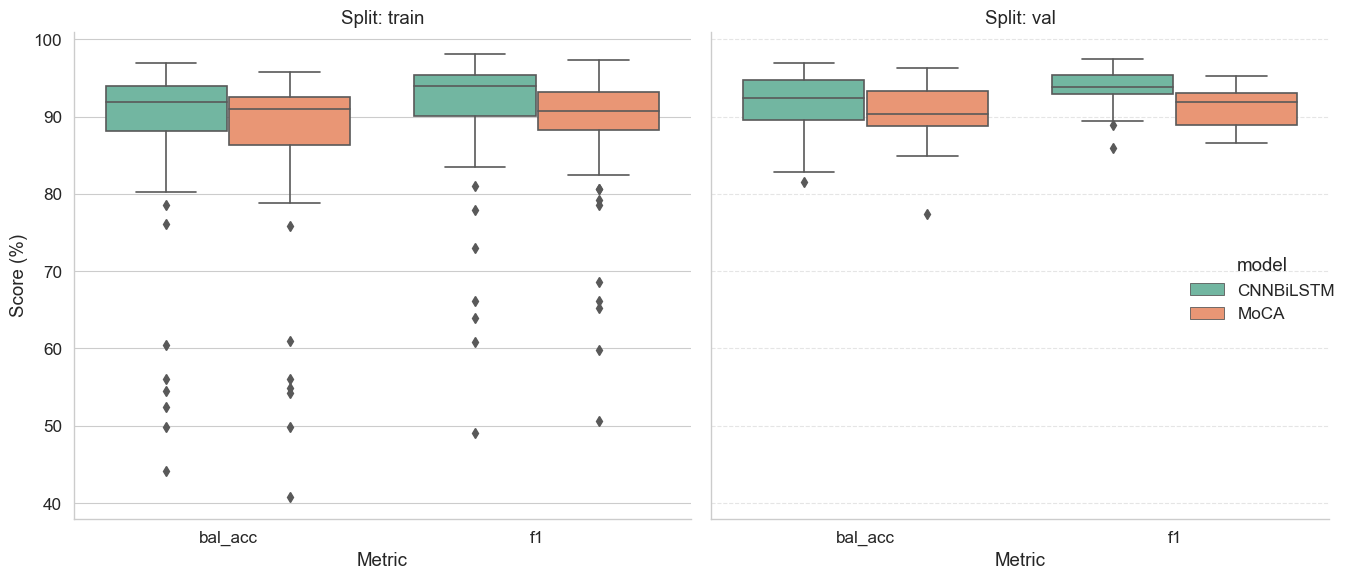

In [16]:
data_paths = [
    '/Users/leo/Desktop/DeepPostures_MAE/MoCA/subject_level_performance/CNNBiLSTMModel/hipset_1.0_blr_0.001_bs_512_input_size_[3, 4200]_subject_performance.pkl',
    '/Users/leo/Desktop/DeepPostures_MAE/MoCA/subject_level_performance/moca_shallow/hipLP_blr_0.001_bs_256_input_size_[3, 100]_subject_performance.pkl'
]

model_names = ['CNNBiLSTM', 'MoCA']

hip_df = plot_model_comparison(data_paths, model_names,)


In [27]:
side_by_side_worst = align_top_10_worst_subjects(hip_df)
print(side_by_side_worst)


            MoCA_bal_acc  CNNBiLSTM_bal_acc
subject_id                                 
i0037A         54.834247          52.396917
i0091A         77.358514          82.833514
i0093A         75.815764          76.083106
i0113A         54.214633          54.470421
i0121A         40.836400          44.174027
i0142A_1       79.988930          81.213635
i0202A         56.088164          55.982056
i0206A         49.809746          49.787126
i0216A_1       78.756019          80.183768
i0226A         61.000231          60.416901
i0352A         79.421574          78.506464
